=== Credit Scoring Model Development ===

1. Generating sample credit data...
Generated 10000 samples
Default rate: 10.51%

2. Preprocessing data...
Data preprocessing completed

3. Splitting data into train/test sets...
Training set: 8000 samples
Test set: 2000 samples

4. Training multiple models...
Training Logistic Regression...
Logistic Regression - CV ROC-AUC: 0.8994 (+/- 0.0187)
Training Random Forest...
Random Forest - CV ROC-AUC: 0.9487 (+/- 0.0223)
Training Gradient Boosting...
Gradient Boosting - CV ROC-AUC: 0.9594 (+/- 0.0098)
Training SVM...
SVM - CV ROC-AUC: 0.8993 (+/- 0.0270)

Model training completed

5. Evaluating models...

Model Performance Summary:
----------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1-Score   ROC-AUC   
----------------------------------------------------------------------
Logistic Regression  0.9145     0.7241     0.3000     0.4242     0.8904    
Random Forest        0.9400 

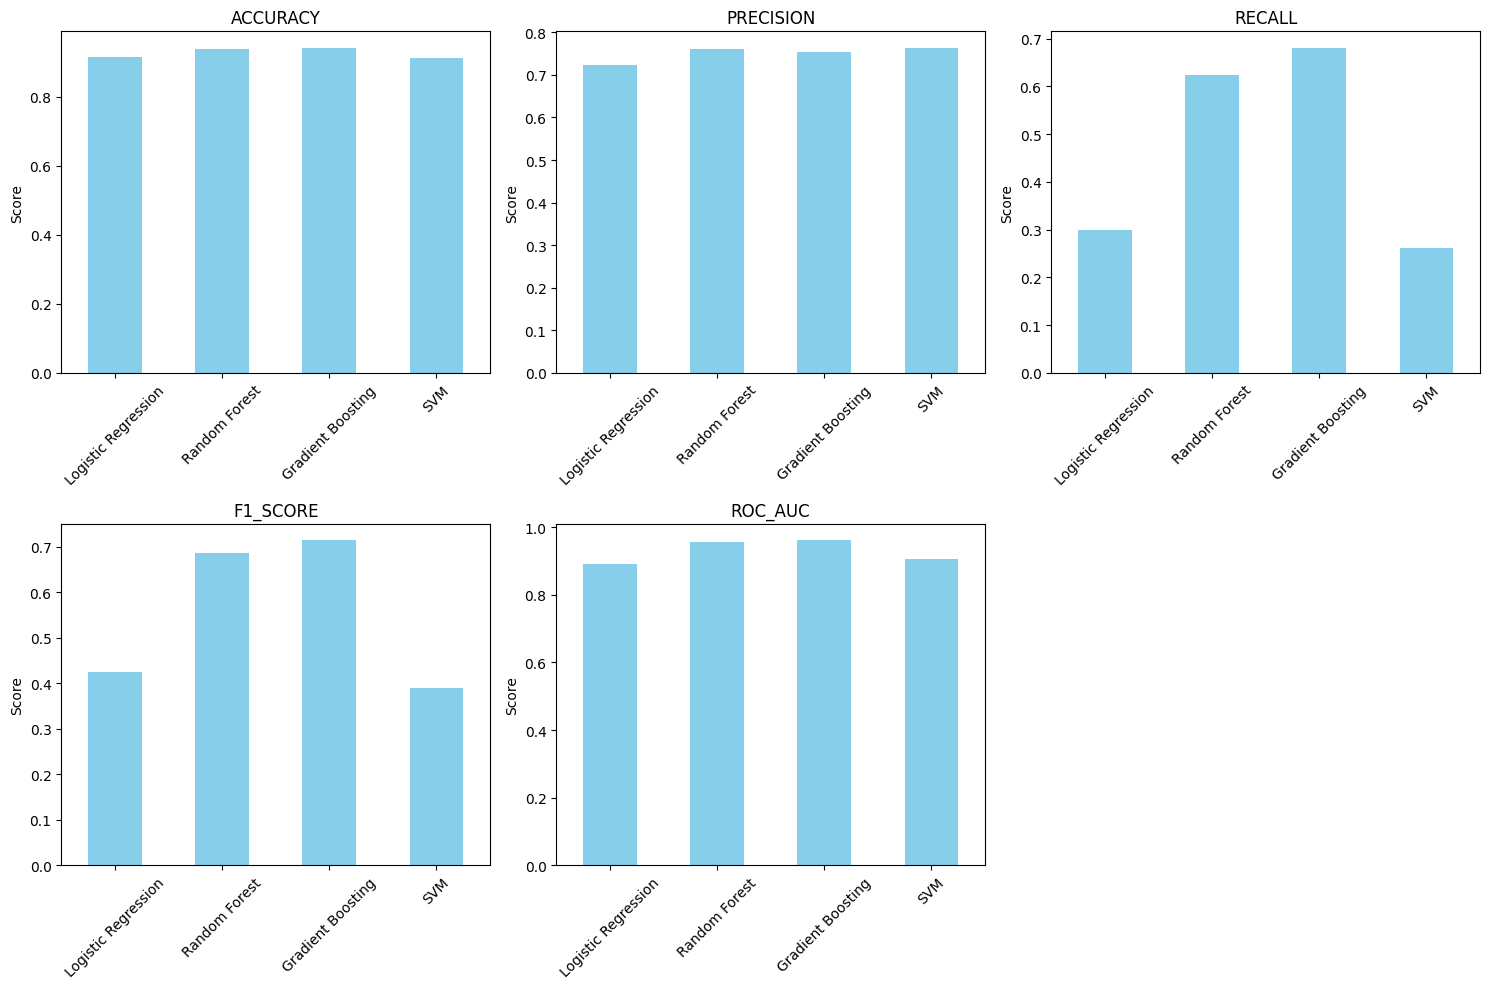

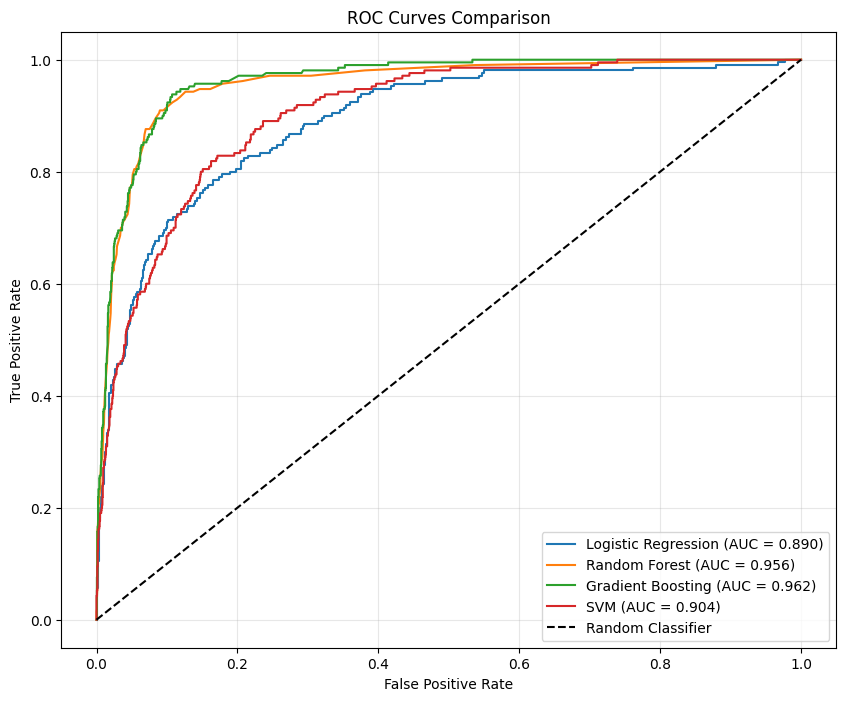

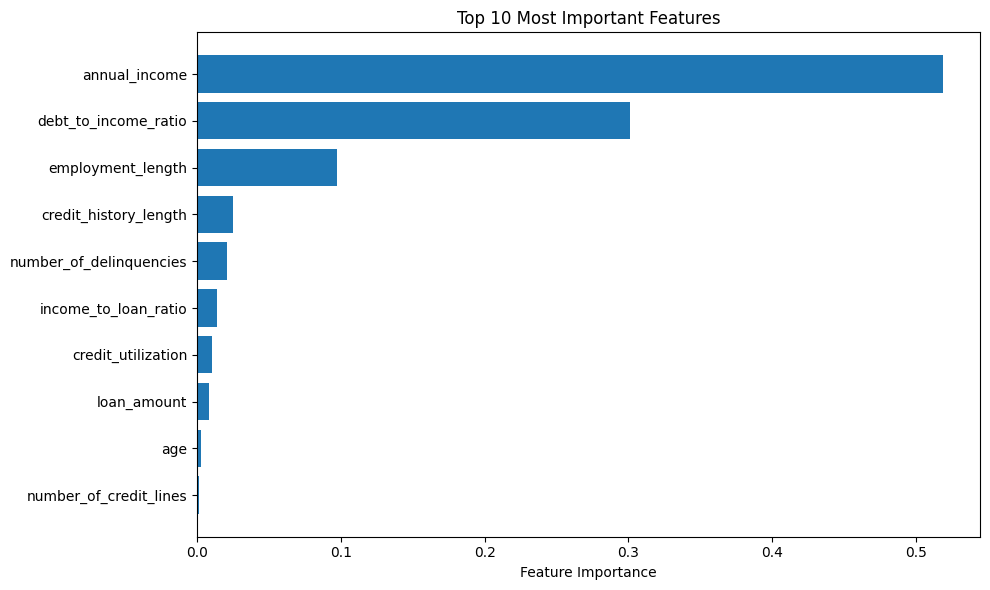


9. Example prediction for a new customer...
Customer Risk Classification: Low Risk
Confidence: 99.7%
Probability of Default: 0.003

=== Credit Scoring Model Development Complete ===


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

class CreditScoringModel:
    def __init__(self):
        self.models = {}
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.best_model = None
        self.feature_importance = None
        
    def generate_sample_data(self, n_samples=10000):
        """Generate realistic sample credit data for demonstration"""
        np.random.seed(42)
        
        # Generate features
        data = {
            'age': np.random.normal(35, 12, n_samples).astype(int),
            'annual_income': np.random.lognormal(10.5, 0.8, n_samples),
            'employment_length': np.random.exponential(5, n_samples),
            'loan_amount': np.random.lognormal(9.5, 0.7, n_samples),
            'debt_to_income_ratio': np.random.beta(2, 5, n_samples),
            'credit_history_length': np.random.gamma(2, 5, n_samples),
            'number_of_credit_lines': np.random.poisson(3, n_samples),
            'number_of_delinquencies': np.random.poisson(0.5, n_samples),
            'home_ownership': np.random.choice(['RENT', 'OWN', 'MORTGAGE'], n_samples, p=[0.4, 0.3, 0.3]),
            'loan_purpose': np.random.choice(['debt_consolidation', 'credit_card', 'home_improvement', 
                                            'major_purchase', 'other'], n_samples, p=[0.3, 0.2, 0.2, 0.15, 0.15])
        }
        
        df = pd.DataFrame(data)
        
        # Clip values to realistic ranges
        df['age'] = np.clip(df['age'], 18, 80)
        df['annual_income'] = np.clip(df['annual_income'], 20000, 200000)
        df['employment_length'] = np.clip(df['employment_length'], 0, 40)
        df['debt_to_income_ratio'] = np.clip(df['debt_to_income_ratio'], 0, 1)
        df['credit_history_length'] = np.clip(df['credit_history_length'], 0, 30)
        df['number_of_delinquencies'] = np.clip(df['number_of_delinquencies'], 0, 10)
        
        # Create target variable based on realistic credit risk factors
        risk_score = (
            (df['annual_income'] < 30000) * 0.3 +
            (df['debt_to_income_ratio'] > 0.4) * 0.25 +
            (df['number_of_delinquencies'] > 2) * 0.2 +
            (df['employment_length'] < 1) * 0.15 +
            (df['credit_history_length'] < 2) * 0.1 +
            np.random.normal(0, 0.1, n_samples)
        )
        
        # Convert to binary classification (0: Good Credit, 1: Bad Credit)
        df['default'] = (risk_score > 0.5).astype(int)
        
        return df
    
    def preprocess_data(self, df):
        """Preprocess the data for machine learning"""
        df_processed = df.copy()
        
        # Handle categorical variables
        categorical_columns = ['home_ownership', 'loan_purpose']
        for col in categorical_columns:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                df_processed[col] = self.label_encoders[col].fit_transform(df_processed[col])
            else:
                df_processed[col] = self.label_encoders[col].transform(df_processed[col])
        
        # Create additional features
        df_processed['income_to_loan_ratio'] = df_processed['annual_income'] / df_processed['loan_amount']
        df_processed['credit_utilization'] = df_processed['debt_to_income_ratio'] * df_processed['number_of_credit_lines']
        
        return df_processed
    
    def split_data(self, df, target_column='default', test_size=0.2):
        """Split data into training and testing sets"""
        X = df.drop(columns=[target_column])
        y = df[target_column]
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        # Scale numerical features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        return X_train_scaled, X_test_scaled, y_train, y_test, X_train.columns
    
    def train_models(self, X_train, y_train):
        """Train multiple classification models"""
        
        # Define models
        models_config = {
            'Logistic Regression': LogisticRegression(random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42),
            'SVM': SVC(probability=True, random_state=42)
        }
        
        # Train models and store results
        for name, model in models_config.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)
            self.models[name] = model
            
            # Cross-validation score
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
            print(f"{name} - CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    def evaluate_models(self, X_test, y_test):
        """Evaluate all trained models"""
        results = {}
        
        for name, model in self.models.items():
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            results[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1_score': f1_score(y_test, y_pred),
                'roc_auc': roc_auc_score(y_test, y_pred_proba)
            }
        
        return results
    
    def plot_model_comparison(self, results):
        """Plot model performance comparison"""
        df_results = pd.DataFrame(results).T
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
        
        for i, metric in enumerate(metrics):
            ax = axes[i//3, i%3]
            df_results[metric].plot(kind='bar', ax=ax, color='skyblue')
            ax.set_title(f'{metric.upper()}')
            ax.set_ylabel('Score')
            ax.tick_params(axis='x', rotation=45)
        
        # Remove empty subplot
        axes[1, 2].remove()
        
        plt.tight_layout()
        plt.show()
    
    def plot_roc_curves(self, X_test, y_test):
        """Plot ROC curves for all models"""
        plt.figure(figsize=(10, 8))
        
        for name, model in self.models.items():
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def select_best_model(self, results):
        """Select the best model based on ROC-AUC score"""
        best_model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
        self.best_model = self.models[best_model_name]
        print(f"Best model: {best_model_name} with ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
        return best_model_name
    
    def get_feature_importance(self, feature_names, model_name=None):
        """Get feature importance from the best model"""
        if model_name:
            model = self.models[model_name]
        else:
            model = self.best_model
        
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = abs(model.coef_[0])
        else:
            print("Model doesn't support feature importance")
            return None
        
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        return feature_importance
    
    def plot_feature_importance(self, feature_importance, top_n=10):
        """Plot feature importance"""
        plt.figure(figsize=(10, 6))
        top_features = feature_importance.head(top_n)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top {top_n} Most Important Features')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    def predict_credit_score(self, customer_data):
        """Predict credit score for new customer"""
        if self.best_model is None:
            raise ValueError("No model has been trained yet!")
        
        # Preprocess the data
        processed_data = self.preprocess_data(customer_data)
        
        # Scale the data
        scaled_data = self.scaler.transform(processed_data)
        
        # Make prediction
        prediction = self.best_model.predict(scaled_data)
        probability = self.best_model.predict_proba(scaled_data)
        
        return prediction, probability

def main():
    """Main function to run the credit scoring model"""
    
    print("=== Credit Scoring Model Development ===\n")
    
    # Initialize the model
    credit_model = CreditScoringModel()
    
    # Step 1: Generate sample data
    print("1. Generating sample credit data...")
    df = credit_model.generate_sample_data(10000)
    print(f"Generated {len(df)} samples")
    print(f"Default rate: {df['default'].mean():.2%}\n")
    
    # Step 2: Preprocess data
    print("2. Preprocessing data...")
    df_processed = credit_model.preprocess_data(df)
    print("Data preprocessing completed\n")
    
    # Step 3: Split data
    print("3. Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, feature_names = credit_model.split_data(df_processed)
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples\n")
    
    # Step 4: Train models
    print("4. Training multiple models...")
    credit_model.train_models(X_train, y_train)
    print("\nModel training completed\n")
    
    # Step 5: Evaluate models
    print("5. Evaluating models...")
    results = credit_model.evaluate_models(X_test, y_test)
    
    # Print results
    print("\nModel Performance Summary:")
    print("-" * 70)
    print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'ROC-AUC':<10}")
    print("-" * 70)
    
    for model_name, metrics in results.items():
        print(f"{model_name:<20} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} "
              f"{metrics['recall']:<10.4f} {metrics['f1_score']:<10.4f} {metrics['roc_auc']:<10.4f}")
    
    print("\n")
    
    # Step 6: Select best model
    print("6. Selecting best model...")
    best_model_name = credit_model.select_best_model(results)
    
    # Step 7: Feature importance
    print("\n7. Analyzing feature importance...")
    feature_importance = credit_model.get_feature_importance(feature_names)
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    
    # Step 8: Model visualization
    print("\n8. Generating visualizations...")
    credit_model.plot_model_comparison(results)
    credit_model.plot_roc_curves(X_test, y_test)
    credit_model.plot_feature_importance(feature_importance)
    
    # Step 9: Example prediction
    print("\n9. Example prediction for a new customer...")
    
    # Create sample customer data
    new_customer = pd.DataFrame({
        'age': [35],
        'annual_income': [75000],
        'employment_length': [5],
        'loan_amount': [25000],
        'debt_to_income_ratio': [0.3],
        'credit_history_length': [10],
        'number_of_credit_lines': [3],
        'number_of_delinquencies': [0],
        'home_ownership': ['MORTGAGE'],
        'loan_purpose': ['debt_consolidation']
    })
    
    try:
        prediction, probability = credit_model.predict_credit_score(new_customer)
        risk_class = "High Risk" if prediction[0] == 1 else "Low Risk"
        confidence = max(probability[0]) * 100
        
        print(f"Customer Risk Classification: {risk_class}")
        print(f"Confidence: {confidence:.1f}%")
        print(f"Probability of Default: {probability[0][1]:.3f}")
        
    except Exception as e:
        print(f"Error in prediction: {e}")
    
    print("\n=== Credit Scoring Model Development Complete ===")
    
    return credit_model, results

# Run the main function
if __name__ == "__main__":
    model, results = main()